# What is the probability of a large nuclear war
- Assuming a climate affect of < -3oC cooling (i.e. 16 Tg of stratospheric soot according to Xia et al., (2022).)

### Probability Density Function of nuclear weapon detonation before 2050
- Using halfway between 2050 and now
- Based on n = 100 and n = 1000 from metaculus: https://www.metaculus.com/questions/11602/number-of-nuclear-detonations-by-2050/
- Deployed nuclear weapons n = 9430 is based on linear interpolation of deployed weapons stockpile inspired by Vasco: https://forum.effectivealtruism.org/posts/gktZ8zuzyh7HEgjfc/famine-deaths-due-to-the-climatic-effects-of-nuclear-war#Probability_of_escalation_into_large_nuclear_war

In [1]:
import os
import random
import numpy as np
import sympy as sym
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

from datetime import datetime
from scipy.interpolate import CubicSpline
from scipy.stats import beta
from scipy.optimize import least_squares

# Set parameters
# Nukes of linear interpolation halfway between 2032 and 2052
# To find out how many nukes between now and halfway to 2050
# https://www.metaculus.com/questions/12722/global-nuclear-warhead-stockpiles/
# Using cubic spline interpolation for smoothness

nukes_2032 = (8.29+10.7)*10**3/2
nukes_2052 = (4.84+13.6)*10**3/2

target_year = int(datetime.now().year+1 + (2050 - datetime.now().year)/2)

cs = CubicSpline(np.array([2032, 2052]), np.array([nukes_2032, nukes_2052]))
max_nukes = int(cs(target_year))
print(f"Cubic Spline interpolation of nukes in {target_year} = {max_nukes}")

def beta_conj(year:int, deton_year1=None, deton_year2=None):
  conjugation = []
  conjugation_PDF = []
  PDF_linspace = []
  det_nom = 1
  det_denom = int(datetime.now().year+1-1945)

  for i in range(year):
    if ((deton_year1 is not None and i == deton_year1) or (deton_year2 is not None and i == deton_year2)):
      det_chance = 1
    else:
      #det_chance = random.randint(1, det_denom)
      det_chance = 0

    if det_chance == 1:
      det_nom += 1
      det_denom += 1

      x_PDF = np.linspace(beta.ppf(0, det_nom, det_denom),
                          beta.ppf(0.95, det_nom, det_denom), 1000)

      next_prob = beta(det_nom, det_denom).mean()
      next_probPDF = beta.pdf(x_PDF, det_nom, det_denom)
      conjugation.append(next_prob)
      conjugation_PDF.append(next_probPDF)
      PDF_linspace.append(x_PDF)
      print(f"Year {datetime.now().year+i+1}: Nuclear detonation occurred. Beta probability set to {det_nom, det_denom} for next year.")

    else:
      det_denom += 1

      x_PDF = np.linspace(beta.ppf(0, det_nom, det_denom),
                          beta.ppf(0.95, det_nom, det_denom), 1000)

      next_prob = beta(det_nom, det_denom).mean()
      next_probPDF = beta.pdf(x_PDF, det_nom, det_denom)
      conjugation.append(next_prob)
      conjugation_PDF.append(next_probPDF)
      PDF_linspace.append(x_PDF)
      print(f"Year {datetime.now().year+i+1}: Nuclear detonation NOT occurred. Beta probability set to {det_nom, det_denom} for next year.")

  return(conjugation, conjugation_PDF, PDF_linspace)

peace_results = beta_conj(target_year - int(datetime.now().year))
one_results = beta_conj(target_year - int(datetime.now().year), 2029 - int(datetime.now().year+1))
two_results = beta_conj(target_year - int(datetime.now().year), 2029 - int(datetime.now().year+1), 2035 - int(datetime.now().year+1))

peace_beta, peace_betaPDF, peace_PDFlinspace = peace_results[0], peace_results[1], peace_results[2]
one_beta, one_betaPDF, one_PDFlinspace = one_results[0], one_results[1], one_results[2]
two_beta, two_betaPDF, two_PDFlinspace = two_results[0], two_results[1], two_results[2]

print(f"Cumulative Probability of peace beta distribution by {target_year} is {sum(peace_beta)}")
print(f"Clmulative Probability of 1-detonation beta distribution by {target_year} is {sum(one_beta)}")
print(f"Cumulative Probability of 2-detonations beta distribution by {target_year} is {sum(two_beta)}")

Cubic Spline interpolation of nukes in 2037 = 9426
Year 2024: Nuclear detonation NOT occurred. Beta probability set to (1, 80) for next year.
Year 2025: Nuclear detonation NOT occurred. Beta probability set to (1, 81) for next year.
Year 2026: Nuclear detonation NOT occurred. Beta probability set to (1, 82) for next year.
Year 2027: Nuclear detonation NOT occurred. Beta probability set to (1, 83) for next year.
Year 2028: Nuclear detonation NOT occurred. Beta probability set to (1, 84) for next year.
Year 2029: Nuclear detonation NOT occurred. Beta probability set to (1, 85) for next year.
Year 2030: Nuclear detonation NOT occurred. Beta probability set to (1, 86) for next year.
Year 2031: Nuclear detonation NOT occurred. Beta probability set to (1, 87) for next year.
Year 2032: Nuclear detonation NOT occurred. Beta probability set to (1, 88) for next year.
Year 2033: Nuclear detonation NOT occurred. Beta probability set to (1, 89) for next year.
Year 2034: Nuclear detonation NOT occur

/Users/christopherchan/mambaforge/envs/m_asrs_trade/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:701: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


In [2]:
def detonation_table(PDF, PDFlinspace):
  beta_df = pd.DataFrame(columns=["year", "linspace", "PDF"])

  # Populate the DataFrame with the data for each year
  for year, linspace, pdf in zip(np.arange(datetime.now().year+1, datetime.now().year+len(PDFlinspace)+1, 1),
                                 PDFlinspace, PDF):
      temp_df = pd.DataFrame({
          "year": year,
          "linspace": linspace,
          "PDF": pdf
      })
      beta_df = pd.concat([beta_df, temp_df], ignore_index=True)

  # Convert the 'year' column to a categorical type for proper legend handling
  beta_df['year'] = beta_df['year'].astype('category')
  print(beta_df.head)

  return beta_df

peace_df = detonation_table(peace_betaPDF, peace_PDFlinspace)
one_df = detonation_table(one_betaPDF, one_PDFlinspace)
two_df = detonation_table(two_betaPDF, two_PDFlinspace)

<bound method NDFrame.head of        year  linspace        PDF
0      2024  0.000000  80.000000
1      2024  0.000037  79.767814
2      2024  0.000074  79.536294
3      2024  0.000110  79.305437
4      2024  0.000147  79.075242
...     ...       ...        ...
13995  2037  0.031572   4.860483
13996  2037  0.031604   4.845853
13997  2037  0.031635   4.831267
13998  2037  0.031667   4.816724
13999  2037  0.031699   4.802225

[14000 rows x 3 columns]>
<bound method NDFrame.head of        year  linspace        PDF
0      2024  0.000000  80.000000
1      2024  0.000037  79.767814
2      2024  0.000074  79.536294
3      2024  0.000110  79.305437
4      2024  0.000147  79.075242
...     ...       ...        ...
13995  2037  0.049275   4.123847
13996  2037  0.049324   4.108257
13997  2037  0.049374   4.092720
13998  2037  0.049423   4.077237
13999  2037  0.049473   4.061807

[14000 rows x 3 columns]>
<bound method NDFrame.head of        year  linspace        PDF
0      2024  0.000000  80.00000

/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_6066/2535102888.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  beta_df = pd.concat([beta_df, temp_df], ignore_index=True)
/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_6066/2535102888.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  beta_df = pd.concat([beta_df, temp_df], ignore_index=True)
/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_6066/2535102888.py:12: FutureWarning: The behavior of DataFrame con

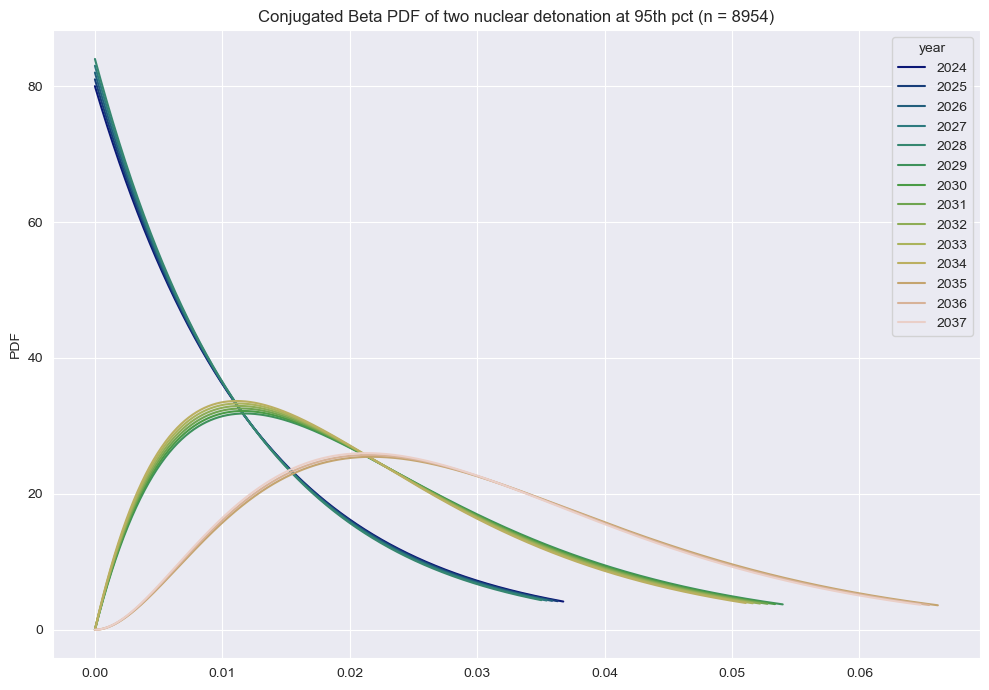

In [7]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize = (10, 7))
sns.lineplot(data=two_df, x="linspace", y="PDF", hue="year", palette="gist_earth").set(
    title="Conjugated Beta PDF of two nuclear detonation at 95th pct (n = 8954)", xlabel = None)

fig.tight_layout()
plt.savefig("../docs/Conj_Beta2D.png")
plt.show()

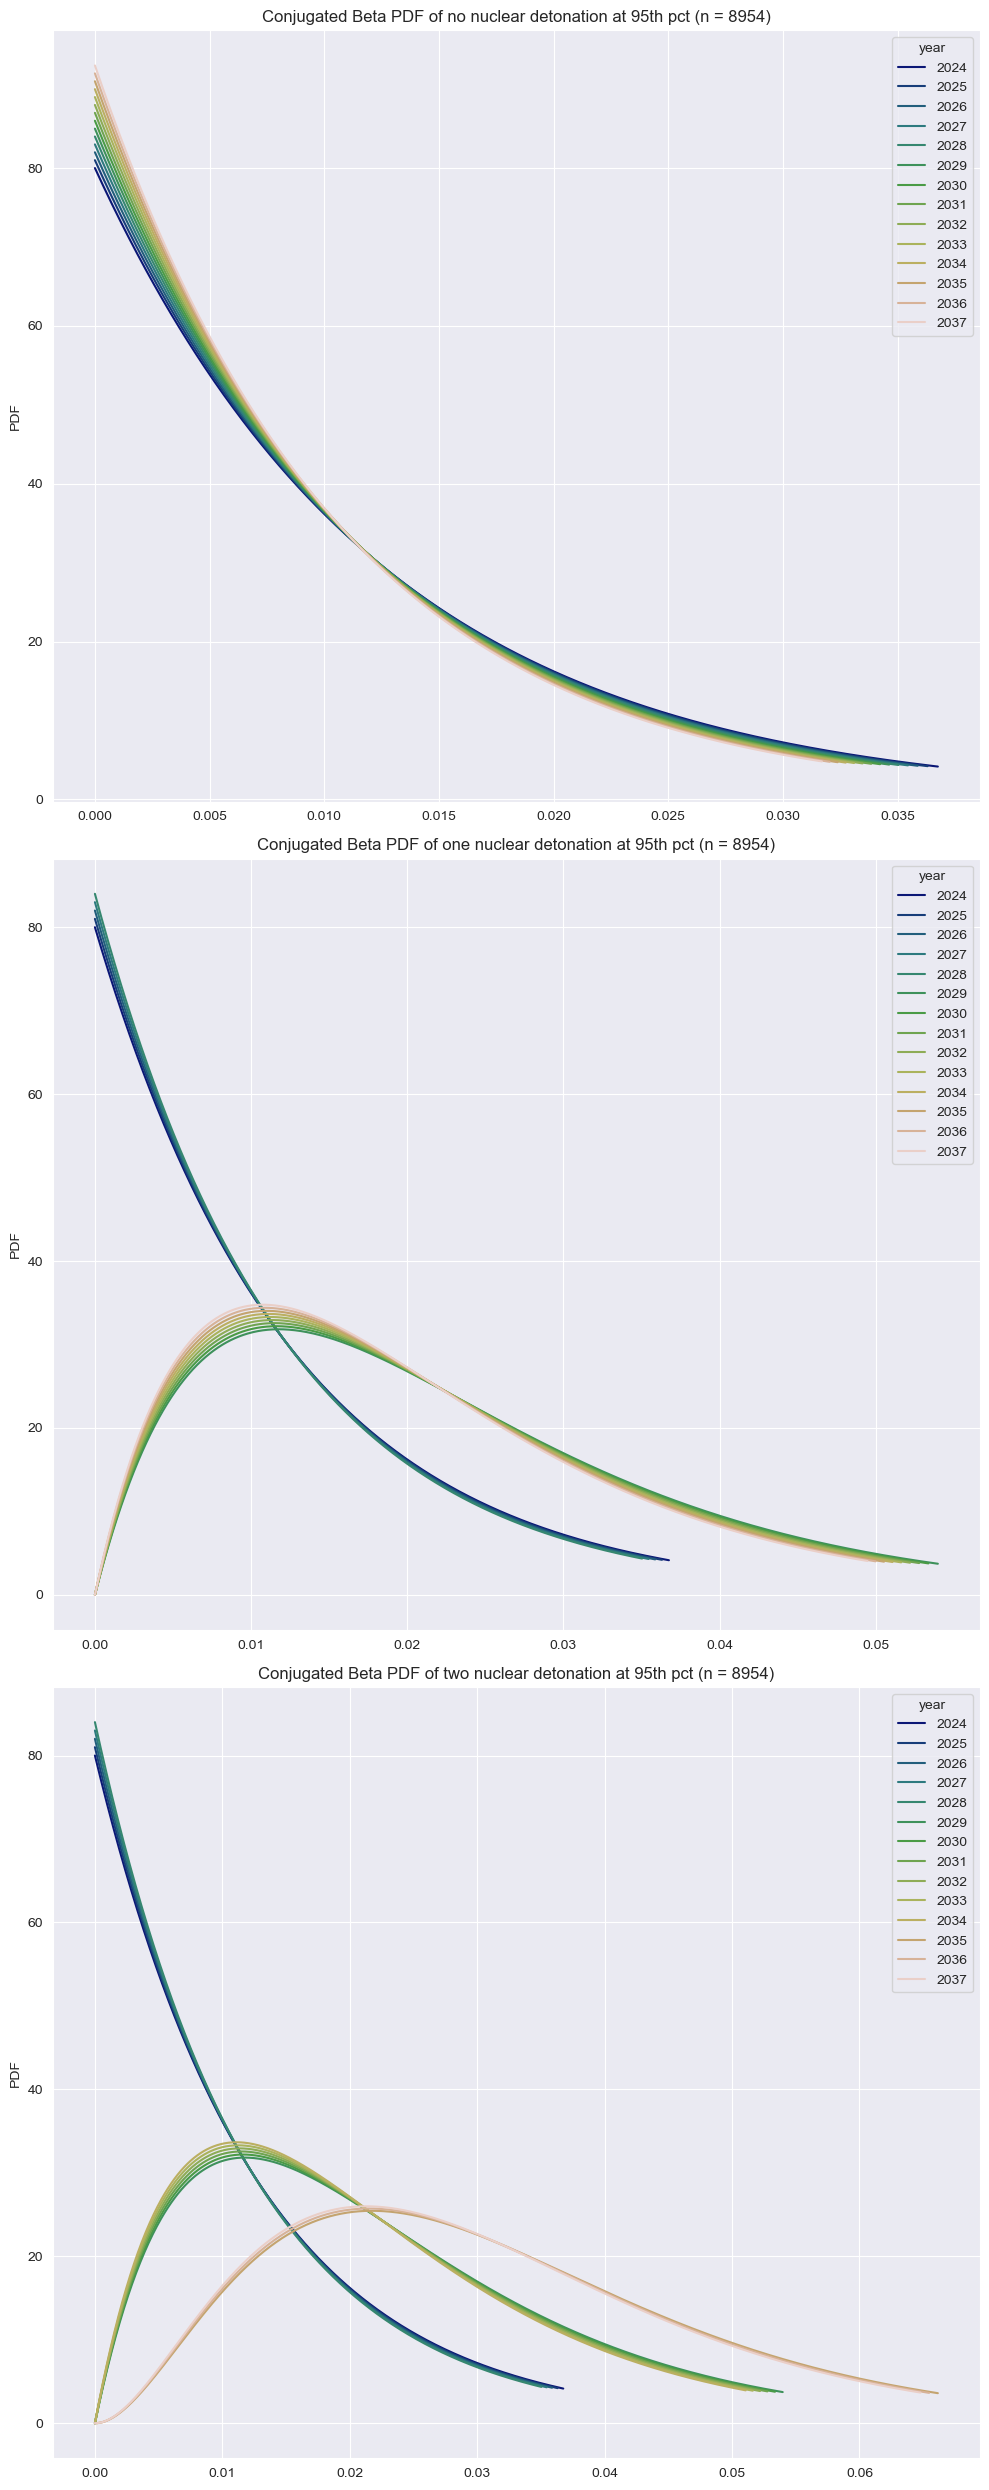

In [8]:
fig, ax = plt.subplots(3,1, figsize = (10, 25))
sns.lineplot(data=peace_df, x="linspace", y="PDF", hue="year", palette="gist_earth", ax=ax[0]).set(
    title="Conjugated Beta PDF of no nuclear detonation at 95th pct (n = 8954)", xlabel = None)
sns.lineplot(data=one_df, x="linspace", y="PDF", hue="year", palette="gist_earth", ax=ax[1]).set(
    title="Conjugated Beta PDF of one nuclear detonation at 95th pct (n = 8954)", xlabel = None)
sns.lineplot(data=two_df, x="linspace", y="PDF", hue="year", palette="gist_earth", ax=ax[2]).set(
    title="Conjugated Beta PDF of two nuclear detonation at 95th pct (n = 8954)", xlabel = None)

fig.tight_layout()
plt.savefig("../docs/Conj_Beta.png")
plt.show()

In [9]:
def objective_function(params, x1, x2, p1, p2):
    alpha, beta_ = params
    cdf_p1 = beta.cdf(x1, alpha, beta_)
    cdf_p2 = beta.cdf(x2, alpha, beta_)
    return [cdf_p1 - p1, cdf_p2 - p2]

def find_alpha_beta(x1, x2, p1, p2):
    # Continuous uniform distribution
    mean = (x1 + x2) / 2
    variance = ((x2 - x1) ** 2) / 12
    #alpha_initial = ((1 - mean) / variance - 1 / mean) * mean ** 2
    #beta_initial = alpha_initial * (1 / mean - 1)
    alpha_initial = mean/(mean+variance)
    beta_initial = (mean*variance)/(mean+variance)**2 * (mean+variance+1)

    initial_guess = [alpha_initial, beta_initial]

    bounds = ([0.001, 0.001], [1000, 1000])  # Bounds for alpha and beta
    sol = least_squares(objective_function, initial_guess, bounds=bounds, args=(x1, x2, p1, p2))

    if sol.success:
        return sol.x
    else:
        return None, None

# Vasco used x1 = 0.106 and x2 = 0.0106, but neither converge to the alpha and beta he listed in the forum
# 100 and 1000 in proportion to max nukes by halfway between now and 2050
x1 = 100/max_nukes
x2 = 1000/max_nukes
p1 = 0.61 # P(100 nukes) = 39% = 0.39 (1-0.61)
p2 = 0.89 # P(1000 nukes) = 11% = 0.11 (1-0.89)

alpha, beta_ = find_alpha_beta(x1, x2, p1, p2)

print(f"alpha = {alpha}, beta = {beta_}")

alpha = 0.18906832579815466, beta = 5.0288625895145


/Users/christopherchan/mambaforge/envs/m_asrs_trade/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:701: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Percentile for 550 detonations: 0.00024127467856023915, 8000 detonations 0.07498134453034738, 75th pct: 0.0342156946706192, 95th pct: 0.19186343195650898
Probability of Large Nuclear War = 0.4497182910628658


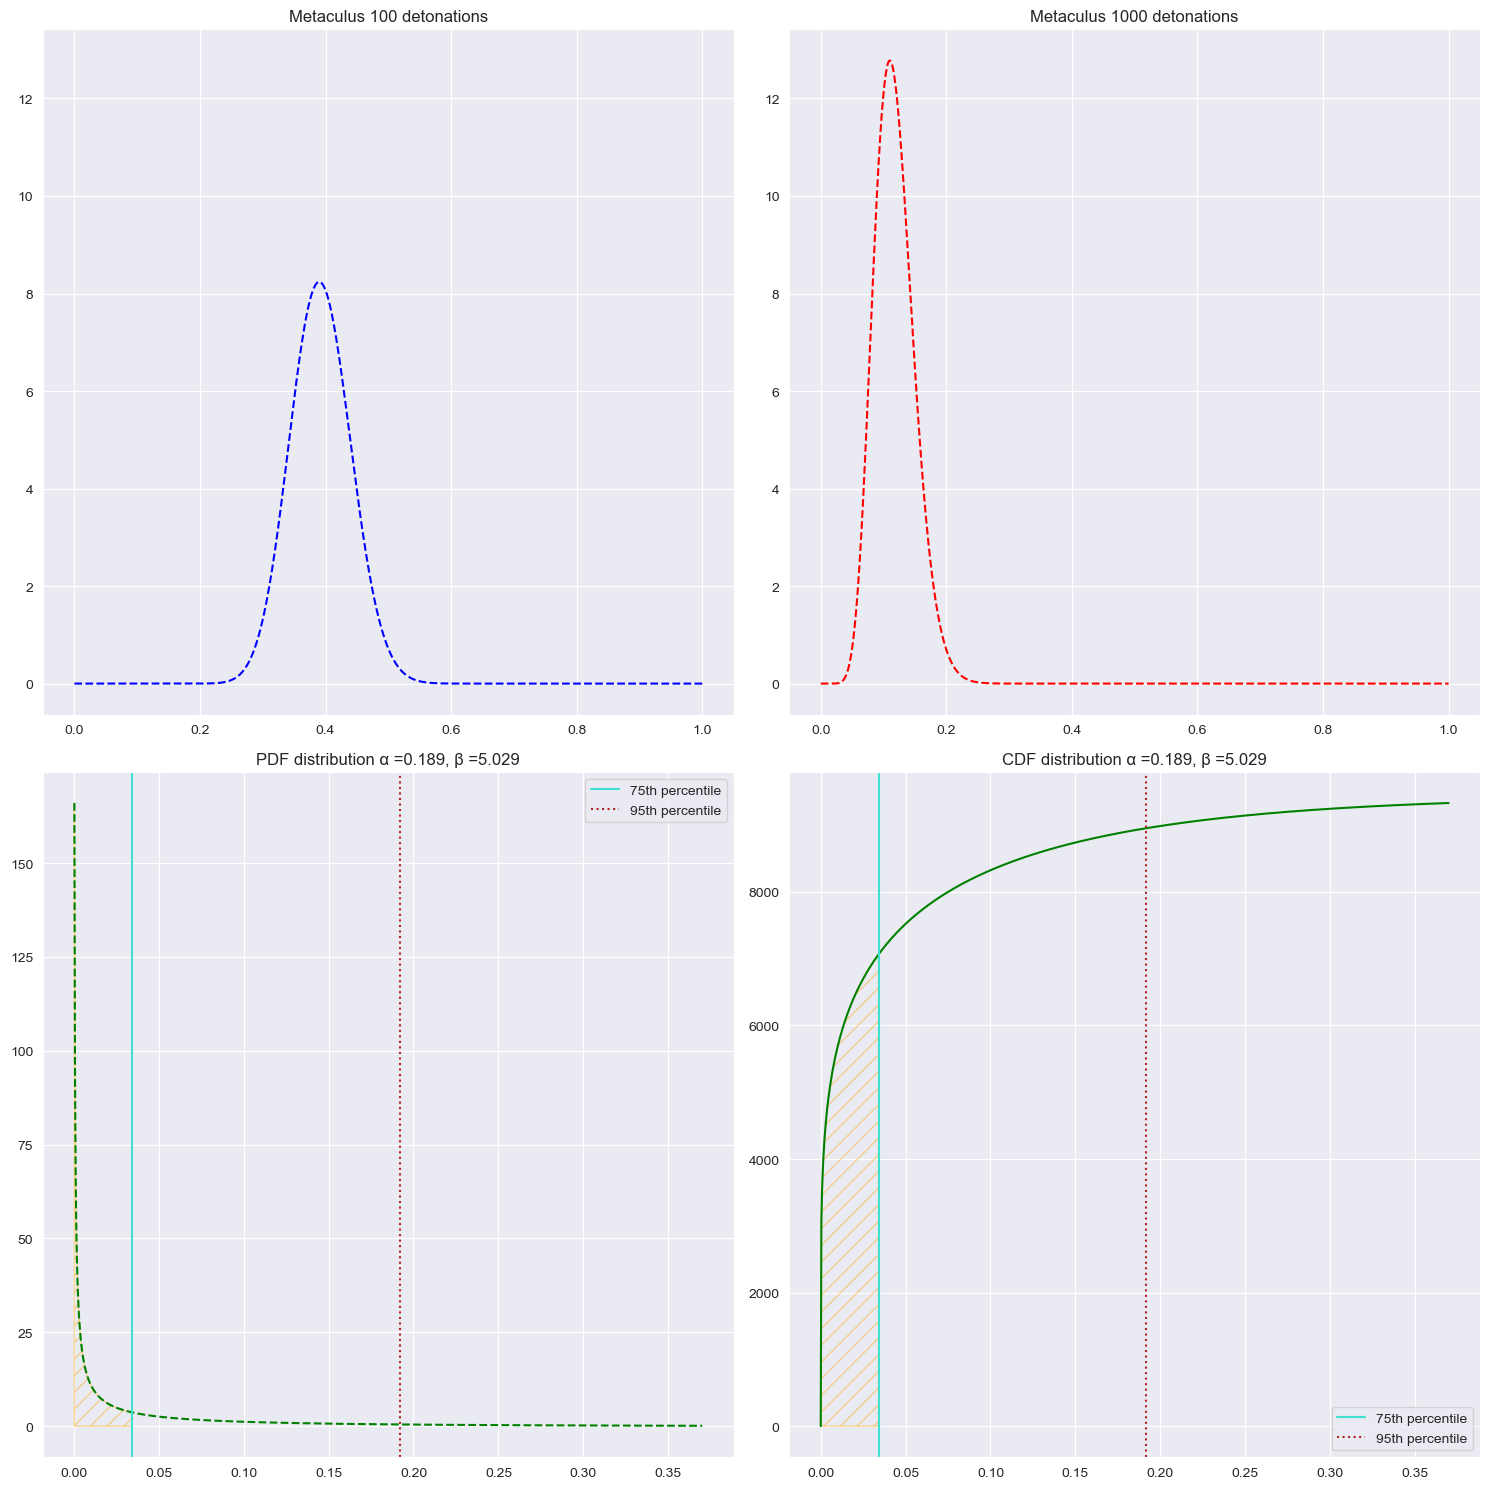

In [10]:
fig, ax = plt.subplots(2, 2, figsize = (15, 15))

x_0 = np.linspace(beta.ppf(0, 0.39*100+1, (1-0.39)*100+1),
                beta.ppf(1, 0.39*100+1, (1-0.39)*100+1), 1000)

x_1 = np.linspace(beta.ppf(0, 0.11*100+1, (1-0.11)*100+1),
                beta.ppf(1, 0.11*100+1, (1-0.11)*100+1), 1000)

pdf_100 = beta.pdf(x_1, 0.39*100+1, (1-0.39)*100+1)
ax[0, 0].plot(x_0, pdf_100, "b--")
ax[0, 0].set_title("Metaculus 100 detonations")

pdf_1000 = beta.pdf(x_1, 0.11*100+1, (1-0.11)*100+1)
ax[0, 1].sharey(ax[0, 0])
ax[0, 1].plot(x_1, pdf_1000, "r--")
ax[0, 1].set_title("Metaculus 1000 detonations")

x_2 = np.linspace(beta.ppf(0, alpha, beta_),
                  beta.ppf(0.99, alpha, beta_), 1000)

pdf = beta.pdf(x_2, alpha, beta_)
cdf = beta.cdf(x_2, alpha, beta_)

perc75 = beta.ppf(.75, alpha, beta_)
perc95 = beta.ppf(.95, alpha, beta_)
perc99 = beta.ppf(.99, alpha, beta_)

# Find percentile for 27 Tg, climatic effect for ASRS
interp_cdf = CubicSpline(cdf, x_2)

# Use ppf and interpolated CDF to find percentile
p8000 = interp_cdf(8000/max_nukes)
p3055 = interp_cdf(3055/max_nukes)
p550 = interp_cdf(550/max_nukes)
assert p550 < perc75, "Percentile is not correct"
print(f"Percentile for 550 detonations: {p550}, 8000 detonations {p8000}, 75th pct: {perc75}, 95th pct: {perc95}")

def integrand(x, a, b):
    return beta.pdf(x, a, b)
pLNW = sp.integrate.quad(integrand, p550, perc75, args=(alpha, beta_))[0]
print(f"Probability of Large Nuclear War = {pLNW}")

# PDF Plot
ax[1, 0].plot(x_2, pdf, "g--")
ax[1, 0].fill_between(x_2, pdf, where=(x_2>=p550) & (x_2<=perc75), alpha = 0.4, facecolor = "none", edgecolor = "orange", hatch = "//")
ax[1, 0].axvline(x = perc75, color = "turquoise", label = "75th percentile")
ax[1, 0].axvline(x = perc95, color = "firebrick", linestyle = ":", label = "95th percentile")
ax[1, 0].set_title(f"PDF distribution \u03B1 ={np.round(alpha, 3)}, \u03B2 ={np.round(beta_, 3)}")
ax[1, 0].legend()

# CDF Plot
ax[1, 1].plot(x_2, cdf*max_nukes, "g")
ax[1, 1].fill_between(x_2, cdf*max_nukes, where=(x_2>=p550) & (x_2<=perc75), alpha = 0.4, facecolor = "none", edgecolor = "orange", hatch = "//")
ax[1, 1].axvline(x = perc75, color = "turquoise", label = "75th percentile")
ax[1, 1].axvline(x = perc95, color = "firebrick", linestyle = ":", label = "95th percentile")
ax[1, 1].set_title(f"CDF distribution \u03B1 ={np.round(alpha, 3)}, \u03B2 ={np.round(beta_, 3)}")
ax[1, 1].legend()

# Show the plot
fig.tight_layout()
plt.savefig("../docs/interCDF_LNW.png")
plt.show()

In [11]:
deton = 100

print(sum(peace_beta)*(1-beta.cdf(deton/max_nukes, alpha, beta_)))
#print(sum(cum_beta)*(beta(deton/max_nukes, alpha, beta_)).mean())

0.06253294560153252
